In [52]:
import torch
from torch import nn
import torchvision

import matplotlib.pyplot as plt
from torchvision import transforms
from torchinfo import summary
from torchmetrics import Accuracy

from pathlib import Path

from going_modular.going_modular import engine, data_setup, get_tensorboard_data
from utilities.helper_functions import plot_loss_curves

## Device agnostic code

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Accuracy metrics

In [30]:
train_accuracy_fn = Accuracy(task='multiclass', num_classes=3).to(device)
test_accuracy_fn = Accuracy(task='multiclass', num_classes=3).to(device)

In [31]:
## Path

dataset_path = Path("datasets/pizza_steak_sushi")
train_dir = dataset_path / "train"
test_dir = dataset_path / "test"

## Normalize

normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

## Transform

# custom transform

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

# auto transform

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()


## Dataloader

BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=data_transform,
                                                                           batch_size=BATCH_SIZE,
                                                                           num_workers=NUM_WORKERS
                                                                           )

train_dataloader, test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x22a9d850c50>,
 ['pizza', 'steak', 'sushi'])

## Use both tranform to understand the difference between them

In [8]:
auto_transform, data_transform

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

## Let's load model

In [44]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [45]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [46]:
summary(model,
        input_size=[32, 3, 245, 245],
        col_names=['input_size', "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 245, 245]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 245, 245]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 245, 245]    [32, 32, 123, 123]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 245, 245]    [32, 32, 123, 123]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 123, 123]   [32, 32, 123, 123]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 123, 123]   [32, 32, 123, 123]   --                   --
│    └─Sequential (1)                                        [32, 32, 123, 123]   [32, 16, 123

## Freeze the pre trained model features section

In [47]:
for param in model.features.parameters():

    param.requires_grad = False

In [48]:
#  (classifier): Sequential(
#     (0): Dropout(p=0.2, inplace=True)
#     (1): Linear(in_features=1280, out_features=1000, bias=True)
#   )

model.classifier = nn.Sequential(

    nn.Dropout(p=0.5,
               inplace=True),
    nn.Linear(in_features=1280,
              out_features=3,
              bias=True)
).to(device)

In [49]:
summary(model,
        input_size=[32, 3, 244, 244],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 244, 244]    [32, 3]              --                   Partial
├─Sequential: 1-1                                       [32, 3, 244, 244]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 244, 244]    [32, 32, 122, 122]   --                   False
│    │    └─Conv2d: 3-1                                 [32, 3, 244, 244]    [32, 32, 122, 122]   (864)                False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 122, 122]   [32, 32, 122, 122]   (64)                 False
│    │    └─SiLU: 3-3                                   [32, 32, 122, 122]   [32, 32, 122, 122]   --                   --
│    └─Sequential: 2-2                                  [32, 32, 122, 122]   [32, 16, 122, 122]   --                   Fal

## Train model

### Loss function and optimizer

In [50]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [51]:
engine.fit_fn(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              train_accuracy_fn=train_accuracy_fn,
              test_accuracy_fn=test_accuracy_fn,
              batch_size=BATCH_SIZE,
              epochs=3,
              summary_write_path="runs/01-Transfer-Learning",
              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 0.8554210662841797 --- | Train Accuracy: 0.5866666436195374


 33%|███▎      | 1/3 [00:11<00:23, 11.99s/it]

Test loss: 1.1451128721237183 --- | Test Accuracy: 0.6133333444595337
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 0.5327273011207581 --- | Train Accuracy: 0.800000011920929


 67%|██████▋   | 2/3 [00:23<00:11, 11.97s/it]

Test loss: 0.2505124807357788 --- | Test Accuracy: 0.8933333158493042
samples remaning: 0 / 256
samples remaning: 64 / 256
samples remaning: 128 / 256
samples remaning: 192 / 256
Train loss: 0.5695105791091919 --- | Train Accuracy: 0.8222222328186035


100%|██████████| 3/3 [00:37<00:00, 12.35s/it]

Test loss: 0.23039022088050842 --- | Test Accuracy: 0.9333333373069763
Total time taken on cuda is 37.0526300999918 secs


In [63]:
model_results = get_tensorboard_data.get_fit_data("runs/01-Transfer-Learning")
model_results

,epoch,train_loss,test_loss,train_accuracy,test_accuracy
0,0,0.855421,1.145113,0.586667,0.613333
1,1,0.532727,0.250512,0.800000,0.893333
2,2,0.569511,0.230390,0.822222,0.933333


In [64]:
model_results.rename(columns={"train_accuracy":"train_acc", "test_accuracy":"test_acc"}, inplace= True, errors="raise")

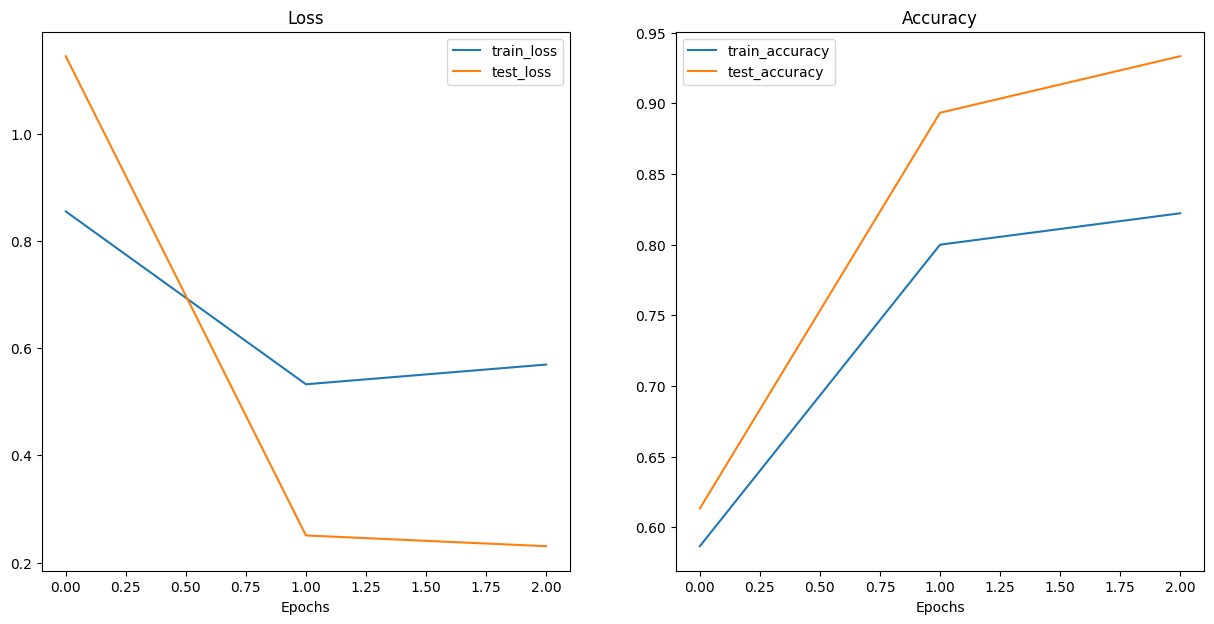

In [68]:
plot_loss_curves(results=model_results)